In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import logging
from helper import getModelDict
delphesDir = os.path.abspath("./DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

c = 3e8

FORMAT = '%(levelname)s: %(message)s at %(asctime)s'
logging.basicConfig(format=FORMAT,datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger()

Welcome to JupyROOT 6.30/06


In [2]:
defaultPars = {'figure.figsize': (5, 4),
               'lines.markersize' : 4,
               'axes.titlesize' : 13,
               'font.size' : 13,
               'axes.labelsize' : 16,
               'xtick.labelsize' : 13,
               'ytick.labelsize' : 13,
               'legend.fontsize' : 10,
               "text.usetex": True,
               "font.family": "sans-serif",
               "font.sans-serif": ["Helvetica"],
               'font.family':'Times New Roman', 
               'font.serif':'Times New Roman',
               "savefig.dpi" : 300,
               'contour.linewidth' : 2.0,
               'lines.linewidth' : 2.0,
               'axes.grid' : True,
               'grid.linewidth' : 0.5,
               'grid.color' : 'lightgray',
               'axes.axisbelow' : True
               }
plt.rcParams.update(defaultPars)

### Files to be compared

In [ ]:
filesDict = {
                r'Signal' : './pp2chi0chi0J_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_delphes_events.root',
                # r'Signal (no smearing)' : './pp2chi0chi0J_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_delphes_events_nosmear.root',
}

modelDict = {}
for key,f in list(filesDict.items()):
    if not os.path.isfile(f):
        print(f'File {f} not found. Skipping.')
        filesDict.pop(key)
    else:
        modelDict[key] = getModelDict(f,verbose=False)

if len(set([tuple(d.items()) for d in modelDict.values()])) > 1:
    print('Several models being used!')
    mDict = None
else:
    mDict = list(modelDict.values())[0]


### Get kinematical variables for each file

In [4]:

cols = ['label',r'$E_T^{\rm miss}(N-1)$ (GeV)',r'$n_{j}(N)$',r'$p_{T}(j_1)(N)$',r'$\Delta \phi^{min} (MET,j)$']


dataList = []
for label,file in filesDict.items():   
    f = ROOT.TFile(file,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    for ievt in range(nevts):
        tree.GetEntry(ievt)

        metOnTime = tree.MissingETOnTime.At(0)
        jetsDelayed = list(tree.JetDelayed)
        jetsDelayed = sorted(jetsDelayed, 
                         key = lambda j: j.PT, reverse=True)

        met = metOnTime.MET
        nj = len(jetsDelayed)
        if nj > 0:
            pTj1 = jetsDelayed[0].PT
            dphi_min = 10000.0
            for j in jetsDelayed[:6]:
                dphi = np.abs(j.Phi-metOnTime.Phi)
                if dphi > np.pi:
                    dphi = 2*np.pi-dphi
                dphi_min = min(dphi,dphi_min)
        else:
            pTj1 = 0.0
            dphi_min = 5.0

        
        
        dataList.append([label,met,nj,pTj1,dphi_min])
    
df = pd.DataFrame(columns=cols,data=dataList)
        

## Plot Distributions

/tmp/ipykernel_54878/491971463.py:49: RuntimeWarning: invalid value encountered in divide
  r_y = np.divide(y,y0)
/tmp/ipykernel_54878/491971463.py:50: RuntimeWarning: invalid value encountered in divide
  r_error = r_y*np.sqrt((yerr/y)**2 + (y0Err/y0)**2)


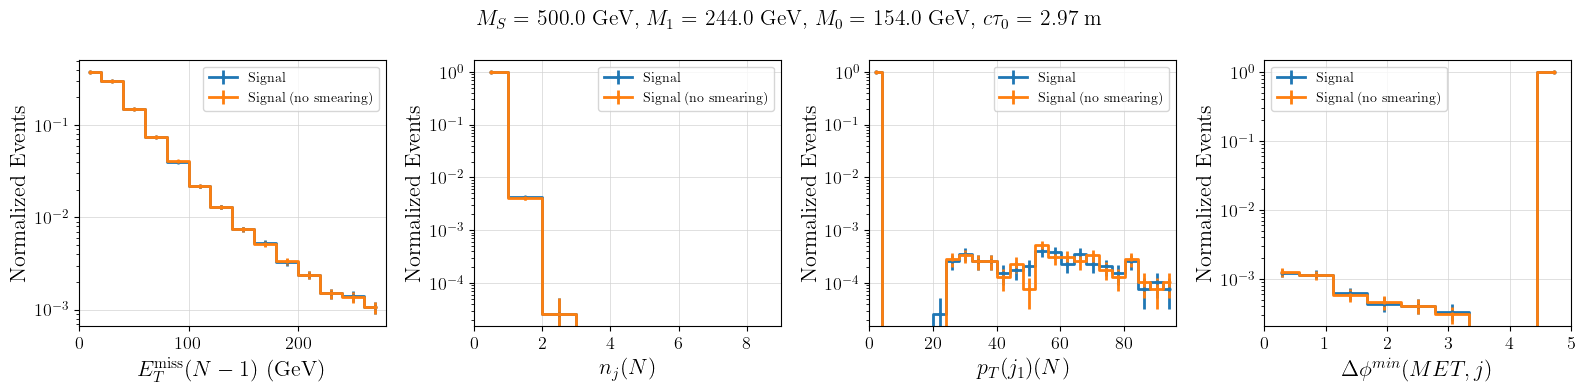

In [7]:
plot_variables = [c for c in df.columns if c not in ['label']]


ncols = len(plot_variables)

nrows = 1
fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(4*ncols,4.0*nrows))

binsDict = {r'$E_T^{\rm miss}(N-1)$ (GeV)' : np.arange(0.,300.,20.), 
            r'$n_{j}(N)$' : np.arange(0.,10.,1.),
            r'$\Delta \phi^{min} (MET,j)$' : np.linspace(0.0,5.0,10)}


for i,var in enumerate(plot_variables):
    v_max, v_min = df[var].max(),df[var].min()
    if var in binsDict:
        bins = binsDict[var]
    else:
        bins = np.linspace(v_min,v_max,25)
    # print(var,bins)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    # ax = axes[0,i]
    ax = axes[i]
    ymax = 0.0
    for j,label in enumerate(df['label'].unique()):
        if 'Signal' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        data = df[df['label'] == label]
        # print('b2=',bins)
        y,_ = np.histogram(data[var], bins=bins)
        yerr = np.sqrt(y)
        norm = sum(y)
        y = y/norm
        ymax = max(ymax,y.max())
        yerr = yerr/norm
        # print('bc=',bin_centers)
        p = ax.errorbar(bin_centers,y,yerr = yerr,marker = '.',drawstyle = 'steps-mid',
                 label=label,linewidth=2,linestyle=ls)
    
        # Plot ratios
        if j == 0:
            y0 = y
            y0Err = yerr
            r_y = np.ones(len(y))
            r_error = np.zeros(len(y))
        else:            
            r_y = np.divide(y,y0)
            r_error = r_y*np.sqrt((yerr/y)**2 + (y0Err/y0)**2)
        
        
    
    ax.set_ylabel('Normalized Events')
    ax.set_yscale('log')
    ax.set_xlim(min(bins),max(bins))
    if i >= 0:
        ax.legend()
    
    ax.set_xlabel(var)

if mDict:
    fig.suptitle(r"$M_{S} =$ %1.1f GeV, $M_{1} = $ %1.1f GeV, $M_0 = $ %1.1f GeV, $c \tau_0$ = %1.2f m" %(mDict['mS'],mDict['m1'],mDict['m0'],c*mDict['tau']))
plt.tight_layout()
plt.show()